# Mass Balance Fitting : 

__Goals__: Outline the model parameters that:
- $\color{green}{ \text{Well know throughout the region}}$
- $\color{blue}{  \text{Determined by model results from Young et al. 2020 / Katie's work}}$
- $\color{red}{   \text{Free parameters that need to be fit as part of this study }}$


$\require{ulem}  
\require{color}$

-------

## Surface Mass Balance Model 

Following Gilbert et al [ 2016, ](test) [ 2020 ](test  )the annual net balance $B$ (kg m$^{-2}$  a$^{-1}$):
$$
\begin{equation}
    B(z) = A(z) + R(z) - M(z) ,
\end{equation}
$$
where:
- $A(z)$ is snow accumulation ( kg m$^{-2}$  a$^{-1}$ )
- $R(z)$ is rate of refreezing ( kg m$^{-2}$  a$^{-1}$ )
- $M(z)$ is surface ablation (melt) ( kg m$^{-2}$  a$^{-1}$ )


### Air Temperature Forcing 
Assuming the surface air temperature $T \textrm{  (K)}$ is modeled as: 

$$
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{equation} 
$$

where:
- $\color{blue}{ \alpha}$ is the annual air temperature amplitude (K), 
- $\color{blue}{ T_{\rm ma}}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\color{green}{ \frac{d T}{dz}}$ is the atmospheric lapse rate (K m$^{-1}$).
- $\color{blue}{ \hat{T}}$ is the DOY of air temperature peak (d)

## Accumulation $A(z)$:

Snow accumulation $A(z)$ is modeled as: 

\begin{equation}
     A_{\rm snow}(z) = \sum^{365}_{d=1} 
    \begin{cases}
    \frac{P_{\rm ref}}{365} +( 1 +  (z-z_{\rm ref})) \frac{d P}{d z} & \text{if } T(d,z) < T_{\rm snow} ,\\
    0 & \text{if } T(d,z) \geq T_{\rm snow} ,
    \end{cases}
\end{equation}

where: 
 - $\color{blue}{ P_{\rm ref}}$ is mean annual precipitation at reference elevation $z_{\rm ref}$  ( kg m$^{-2}$  a$^{-1}$ ), 
 - $\color{blue}{ \frac{d P}{d z}}$ altitudinal precipitation factor, $ \color{red}{Maybe???}$  ( m$^{-1}$ )
 - $\color{blue}{ T_{\rm snow}}$  snow versus rain temperature threshold  $(K)$*


## Melt $M(z)$: 

The annual melt $M(z)$ is modeled as 
\begin{equation}
    M_{\rm melt}(z) = \sum^{365}_{d=1} \max\left[ \left( T(d,z) - T_{\rm melt} \right) f_{\rm m}(x), 0\right] ,
\end{equation}
where: 
 - $\color{blue}{T_{\rm melt}}$ is the temperature threshold for melting (K)
 - $f_{\rm m}(x)$ is the nodally specific degree day factor described below ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$)

## Refreezing $R(z)$: 

We assume refreezing from previous years creates impermeable layers, meaning refreezing can only occur to a depth at maximum equal the annual accumulation, such that:

\begin{equation}
    R(z) = \min \left[ M_{\rm melt}(z), f_{\rm r} A_{\rm snow}(z) \right], 
\end{equation}
where:
- $\color{red}{f_{\rm r}}$ is the refreezing factor (the proportion of annual melt that refreezes) [-]. 


## Degree Day Factor $f_{\rm m}(x)$:  

We calculate the nodal degree day factor as:

\begin{equation}
    f_{\rm m}(z) = 
    \begin{cases}
        f_{\rm snow}                                          & \text{if } r_{\rm s/m}(z) \geq 1 , \\
        f_{\rm ice} - (f_{\rm ice} - f_{\rm snow})r_{\rm s/m}(z) & \text{if } r_{\rm s/m}(z) < 1 ,\\
    \end{cases}
\end{equation}
where
\begin{equation}
    r_{\rm s/m}(z) = \frac{A(z)}{M(z)} . 
\end{equation}
- $\color{red}{f_{\rm ice} }$  is the degree day factor for ice  ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$)
- $\color{red}{f_{\rm snow} }$ is the degree day factor for snow ( kg m$^{-2}$  a$^{-1}$ K$^{-1}$)



The nodal specific $f_{\rm m}$ should be bounded by $f_{\rm ice}$ and $f_{\rm snow}$. 

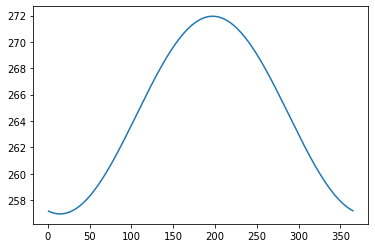

In [114]:
import numpy as np 
import xarray as xr 
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt 

z         = 2193.0
temp_peak = 365./1.85 # DOY of annual temp peak      [doy]
ref_z     = 2193.0  # reference surface elevation  [m a.s.l.]
T_mean    = 264.45  # Mean annual air temp @ ref_z [K]
α         = 7.5     # anual air temp. amplitude    [K]
ΔTΔz      = 6.5E-3  # air temp lapse rate          [K m^-1]
DOY       = np.linspace(1,365,365)[:,np.newaxis]
T         = α*np.cos( 2*np.pi*(DOY-temp_peak)/365 )+ΔTΔz*(ref_z-z)+T_mean


plt.plot(DOY, T)

In [142]:
fp = "/Users/andrewnolan/Downloads/Daily_Kaskawulsh_air_temperature_files/Daily_Temperature{}.npy"

temp_arrays = [ ]
for year in np.arange(2007, 2019):
    test = np.load(fp.format(year))
    
    temp_arrays.append(test)

temps = np.hstack(temp_arrays)
time  = pd.date_range(start='1/1/2007', end='12/31/2018')


temperature = xr.DataArray(temps, coords=[time], dims=["time"])


X = np.load('/Users/andrewnolan/Downloads/X_grid.npy')
Y = np.load('/Users/andrewnolan/Downloads/Y_grid.npy')
Z = np.load('/Users/andrewnolan/Downloads/Elevation_grid.npy')

MB    = np.load("/Users/andrewnolan/Downloads/Daily_Kaskawulsh_air_temperature_files/MBArray_Tempshift_-0.9.npy")
melt  = np.load("/Users/andrewnolan/Downloads/Daily_Kaskawulsh_air_temperature_files/NetMeltArray_Tempshift_-0.9.npy")
accum = np.load("/Users/andrewnolan/Downloads/Daily_Kaskawulsh_air_temperature_files/AccumulationArray_Tempshift_-0.9.npy")
rain  = np.load("/Users/andrewnolan/Downloads/Daily_Kaskawulsh_air_temperature_files/RainArray_Tempshift_-0.9.npy")

coords={
    "lon": (["x", "y"], X),
    "lat": (["x", "y"], Y),
    "time" : time
}
    
ds = xr.Dataset( {
    "Accumulation": xr.DataArray(
                    data   = accum.mean(axis=0) * 1e3/910.,
                    dims   = ["x", "y"],
                    coords = {key: coords[key] for key in coords.keys() if key != 'time'}, 
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : '(m i.e.q.) yr^-1'
                        }),
    "Melt"        : xr.DataArray(
                    data   = melt.mean(axis=0) * 1e3/910.,
                    dims   = ["x", "y"],
                    coords = {key: coords[key] for key in coords.keys() if key != 'time'}, 
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : '(m i.e.q.) yr^-1'
                        }),
    "MB"        : xr.DataArray(
                    data   = MB.mean(axis=0) * 1e3/910.,
                    dims   = ["x", "y"],
                    coords = {key: coords[key] for key in coords.keys() if key != 'time'},
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : '(m i.e.q.) yr^-1'
                        }),
    "Rain"      : xr.DataArray(
                    data   = rain.mean(axis=0) * 1e3/910.,
                    dims   = ["x", "y"],
                    coords = {key: coords[key] for key in coords.keys() if key != 'time'},
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : '(m i.e.q.) yr^-1'
                        }),    
    
    "Elevation" : xr.DataArray(
                    data   = Z,
                    dims   = ["x", "y"],
                    coords = {key: coords[key] for key in coords.keys() if key != 'time'}, 
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : 'm a.s.l.'
                        }),
    
    "temp"      : xr.DataArray(
                    data   = temperature,
                    dims   = ["time"],
                    coords = {"time" : time}, 
                    attrs  = {'_FillValue': np.nan, 
                              'units'     : 'deg C'
                        })},        
    attrs = {'Note': 
             "Runs from Katie Robinson on 10/13/2021 with a -0.9C offset to temperature record from Young et al. 2020"}
)

In [160]:
ds.to_netcdf("Young_etal_2020_Delta_T_-0.9_C.nc")

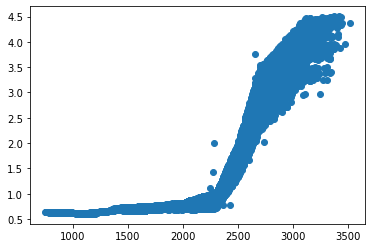

In [158]:
plt.scatter(ds.stack(z=('x', 'y')).Elevation, ds.stack(z=('x', 'y')).Accumulation + ds.stack(z=('x', 'y')).Rain)


In [ ]:
ds.stack(z=('x', 'y')).Accumulation.plot

In [ ]:
ds.stack(z=('x', 'y')).Accumulation.plot.scatter

In [134]:
accum.shape

(12, 218, 328)

In [132]:
MB.shape

(12, 218, 328)

In [133]:
melt.shape

(12, 218, 328)

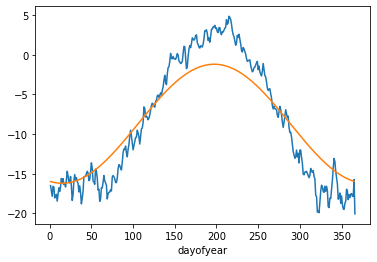

In [117]:
temperature.groupby("time.dayofyear").mean().plot()
plt.plot(DOY, T-273.15)

In [126]:
print(temperature.groupby("time.dayofyear").mean().sum().values)
print((T-273.15).sum())

-3181.7368
-3175.499999999996


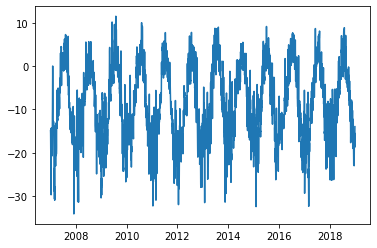

In [41]:
plt.plot(
    pd.date_range(start='1/1/2007', end='12/31/2018'), 
    np.hstack(temp_arrays) )

In [87]:
f, Pxx = signal.periodogram(temperature.groupby("time.dayofyear").mean(), 
                            1/(60*60*24), scaling = 'spectrum')

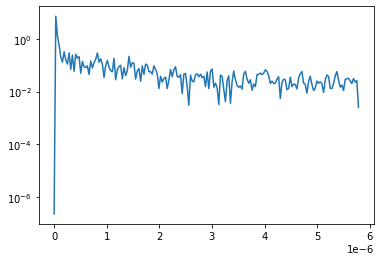

In [88]:
plt.semilogy(f, np.sqrt(Pxx))

In [93]:
(1/f[np.argmax(np.sqrt(Pxx))]) / (60*60*24)

365.99999999999994

In [94]:
np.max(np.sqrt(Pxx))

7.483615

In [100]:
test = xr.open_dataset("../Young_etal_2020_ref_MB.nc")

In [105]:
test.Elevation.mean()

<xarray.DataArray 'Elevation' ()>
array(2193.00864293)